## Model evaluation

This notebook contains the code to compare two models that seem to perform the best in the model training phase.

In [64]:
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt



In [65]:
df = pd.read_parquet("data/air-quality-idx-eval.parquet.gzip")
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Timestamp,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
42616,2018-11-15 17:00:00,50.0,1030.8,83.0,0.0,8.9,218.0,6.3
42617,2018-11-15 18:00:00,53.0,1031.1,84.0,0.0,9.0,222.0,5.3
42618,2018-11-15 19:00:00,55.0,1031.6,86.0,0.0,8.7,225.0,5.5
42619,2018-11-15 20:00:00,45.0,1032.0,84.0,0.0,9.0,224.0,6.1
42620,2018-11-15 21:00:00,47.0,1032.0,86.0,0.0,8.8,223.0,6.1


## Evaluate LSTM only using air quality index data with lag size=1

In [66]:
# we only have a single feature
features = 1

# prepare data & normalize with robust scaler
series = df["Mannerheimintie"].values.reshape((len(df["Mannerheimintie"]), features))
scaler = RobustScaler()
series = scaler.fit_transform(series)

eval_generator = TimeseriesGenerator(series, series, length=1, batch_size=64)
    

In [67]:
model = load_model("models/lstm-look-back-1.h5")

In [68]:
yhat = model.predict_generator(eval_generator)
predictions = scaler.inverse_transform(yhat)
y = scaler.inverse_transform(series)
error = mean_squared_error(y[1:], predictions)

Text(0.5, 1.0, 'MSE: 85.86601454378341')

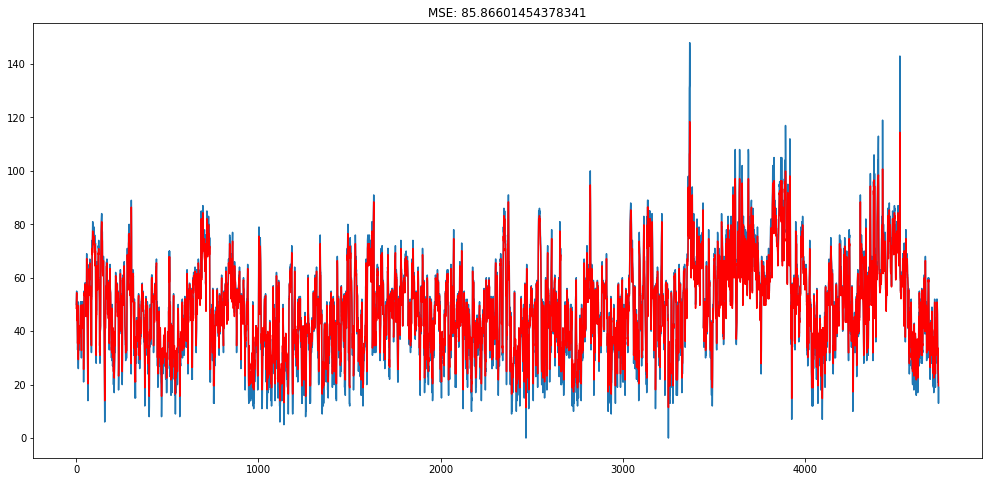

In [69]:
plt.figure(figsize=(17,8))
plt.plot(y)
plt.plot(predictions, color='red')
plt.title("MSE: {}".format(error))



Let's zoom in to the last 200 predictions to get a better look

Text(0.5, 1.0, 'MSE: 85.86601454378341')

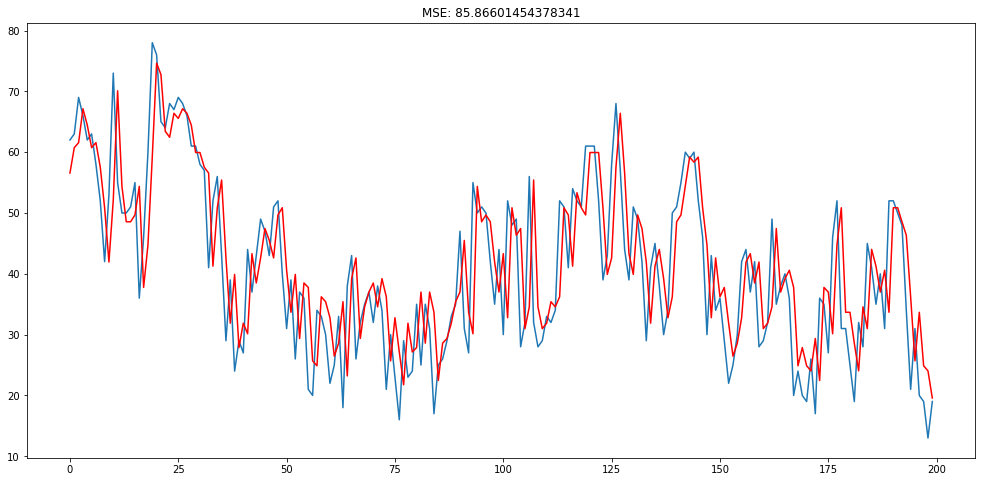

In [70]:
plt.figure(figsize=(17,8))
plt.plot(y[-200:])
plt.plot(predictions[-200:], color='red')
plt.title("MSE: {}".format(error))

## Evaluate model that incorporates weather data

In [71]:
features=7

# prepare data into supervised learning problem by separating X and y
y = df["Mannerheimintie"].values
y = y.reshape(-1, 1)

X = df.drop("Timestamp", axis=1)
X = X.values

scaler_X = RobustScaler()
X = scaler_X.fit_transform(X)
scaler_y = RobustScaler()
y = scaler_y.fit_transform(y)
eval_generator = TimeseriesGenerator(X, y, length=2, batch_size=64)

In [72]:
joblib.dump(scaler_X, "models/scaler_X.pkl")
joblib.dump(scaler_y, "models/scaler_y.pkl")

['models/scaler_y.pkl']

In [73]:
model = load_model("models/lstm-weather-data-look-back-1.h5")

In [74]:
yhat = model.predict_generator(eval_generator)
predictions = scaler_y.inverse_transform(yhat)
y1 = scaler_y.inverse_transform(y[2:])
error = mean_squared_error(y1, predictions)

Text(0.5, 1.0, 'MSE: 85.22068281055321')

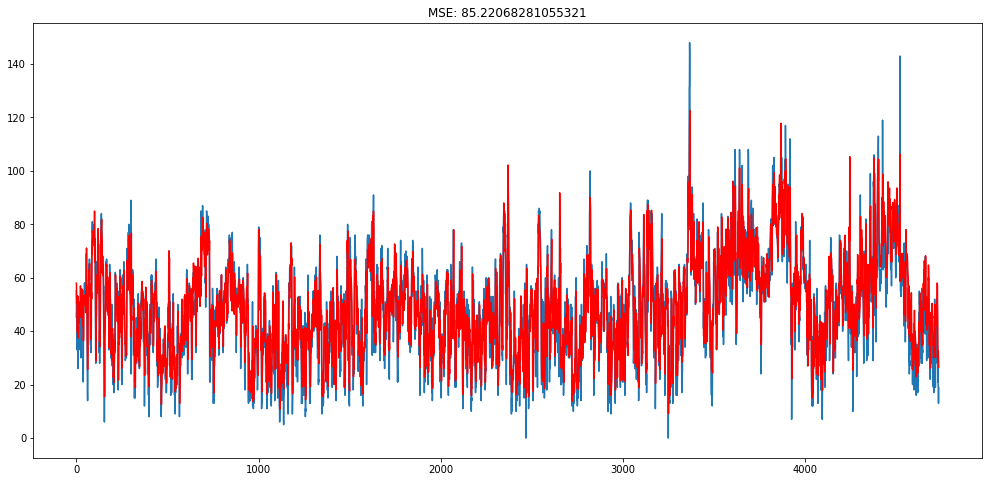

In [75]:
plt.figure(figsize=(17,8))
plt.plot(y1)
plt.plot(predictions, color='red')
plt.title("MSE: {}".format(error))

Text(0.5, 1.0, 'MSE: 85.22068281055321')

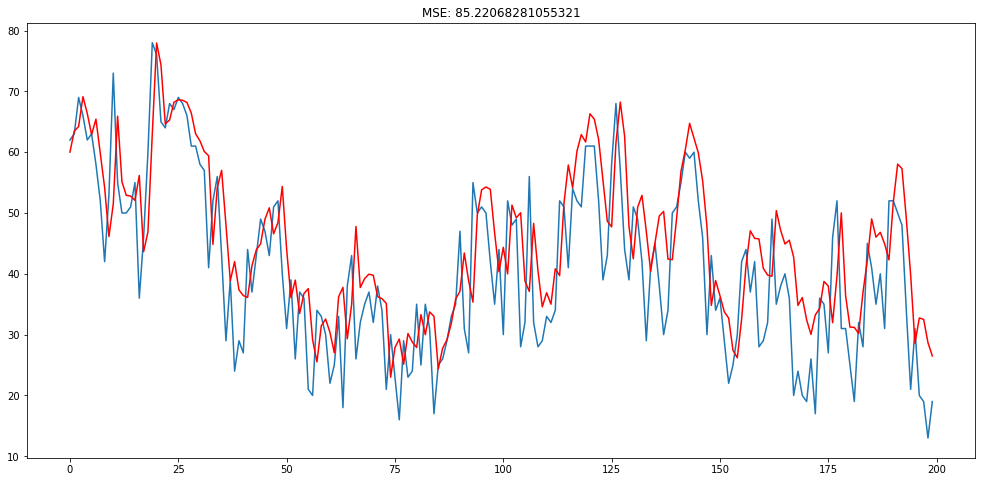

In [76]:
plt.figure(figsize=(17,8))
plt.plot(y1[-200:])
plt.plot(predictions[-200:], color='red')
plt.title("MSE: {}".format(error))

## Evaluate model with filters

In [83]:
df = pd.read_parquet("data/air-quality-idx-eval-2.parquet.gzip")
df = df.filter(["Mannerheimintie", "Rolling-mean", "Rolling-std", "Signal"])
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Mannerheimintie,Rolling-mean,Rolling-std,Signal
46878,36.0,48.000000,10.583005,39.689053
46879,36.0,41.333333,9.237604,33.729814
46880,10.0,27.333333,15.011107,14.540373
46881,36.0,27.333333,15.011107,31.118246
46882,18.0,21.333333,13.316656,25.047743


In [89]:
features=4

# prepare data into supervised learning problem by separating X and y
y = df["Mannerheimintie"].values
y = y.reshape(-1, 1)

X = df.values

scaler_X = RobustScaler()
X = scaler_X.fit_transform(X)
scaler_y = RobustScaler()
y = scaler_y.fit_transform(y)
eval_generator = TimeseriesGenerator(X, y, length=8, batch_size=64)
eval_generator2 = TimeseriesGenerator(X, y, length=1, batch_size=64)


model = load_model("models/lstm-filter-data-look-back-8.h5")
model2 = load_model("models/lstm-filter-data-look-back-1.h5")



In [91]:
yhat = model.predict_generator(eval_generator)
predictions = scaler_y.inverse_transform(yhat)
y1 = scaler_y.inverse_transform(y[8:])
error = mean_squared_error(y1, predictions)

yhat2 = model2.predict_generator(eval_generator2)
predictions2 = scaler_y.inverse_transform(yhat2)
y2 = scaler_y.inverse_transform(y[1:])
error2 = mean_squared_error(y2, predictions2)

Text(0.5, 1.0, 'Lag size: 1, MSE: 67.6510249433926')

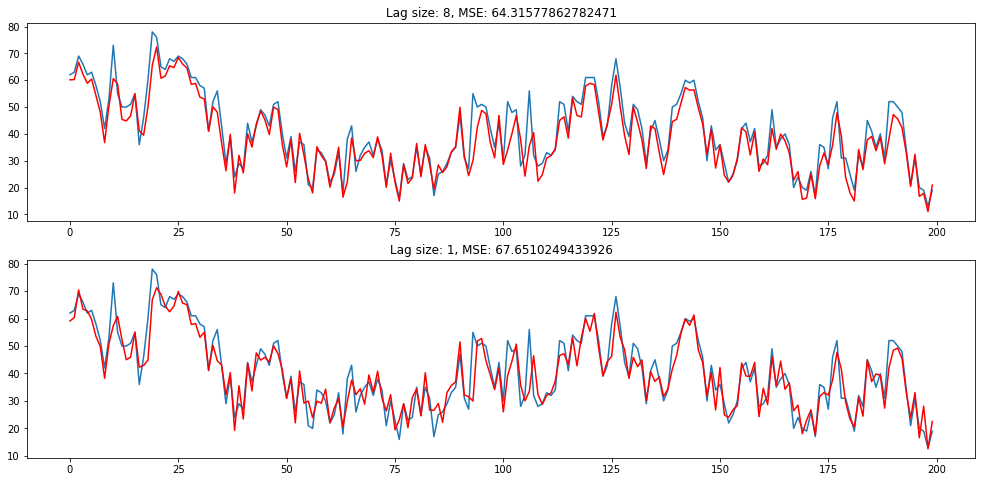

In [93]:
plt.figure(figsize=(17,8))
plt.subplot(2, 1, 1)
plt.plot(y1[-200:])
plt.plot(predictions[-200:], color='red')
plt.title("Lag size: 8, MSE: {}".format(error))

plt.subplot(2, 1, 2)
plt.plot(y1[-200:])
plt.plot(predictions2[-200:], color='red')
plt.title("Lag size: 1, MSE: {}".format(error2))

## Summary

Each model performs suprisingly well with the evaluation data with MSE of 85, 85 and 68. It looks like that the weather data does not improve the model's predictive capabilities. Model that uses filter values performs the best also with the evalution data.